## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from itertools import chain
import scipy
import tensorflow as tf
from skimage import io
import sklearn.model_selection as skl
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
66515,00016441_000.png,No Finding,0,16441,56,F,PA,2526,2433,0.143,0.143,NaN,/data/images_008/images/00016441_000.png
39432,00010334_004.png,No Finding,4,10334,67,M,PA,2778,2781,0.143,0.143,NaN,/data/images_005/images/00010334_004.png
12752,00003352_000.png,No Finding,0,3352,42,F,PA,2048,2500,0.171,0.171,NaN,/data/images_002/images/00003352_000.png


In [3]:
# Drop any unreasonable ages!
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 120]
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # ignore empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
8656,00002288_012.png,Nodule,12,2288,61,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,0,0
22215,00005892_018.png,No Finding,18,5892,56,F,PA,2626,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
99843,00026451_017.png,Consolidation|Pleural_Thickening,17,26451,51,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia']==1, 'Pneumonia', 'No Pneumonia')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,No Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,No Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,No Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,No Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,No Pneumonia


In [6]:
all_xray_df['Pneumonia'].sum()


1430

## Create your training and testing data:

In [7]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    ## It's important to consider here how balanced or imbalanced we want each of those sets to be
    ## for the presence of pneumonia
    
    pmonia_df = all_xray_df[all_xray_df['Pneumonia'] == 1]
    non_pmonia_df = all_xray_df[all_xray_df['Pneumonia'] == 0]
    train_data, val_data = skl.train_test_split(pmonia_df, test_size = 0.2)
    train_non_pmonia_data, val_non_pmonia_data = skl.train_test_split(non_pmonia_df, test_size = 0.5)
    train_non_pmonia_data = train_non_pmonia_data.sample(train_data.shape[0])
    train_data = pd.concat([train_data, train_non_pmonia_data])
    non_pmonia_test_count = int((val_data.shape[0] / 1.2) * 98.8)
    val_non_pmonia_data = val_non_pmonia_data.sample(non_pmonia_test_count)
    val_data = pd.concat([val_data, val_non_pmonia_data])
    
    return train_data, val_data

train_df, valid_df = create_splits(all_xray_df)


In [8]:
train_df['Pneumonia'].value_counts()


1    1144
0    1144
Name: Pneumonia, dtype: int64

In [9]:
valid_df['Pneumonia'].value_counts()


0    23547
1      286
Name: Pneumonia, dtype: int64

Text(0, 0.5, 'Number of x-ray observations')

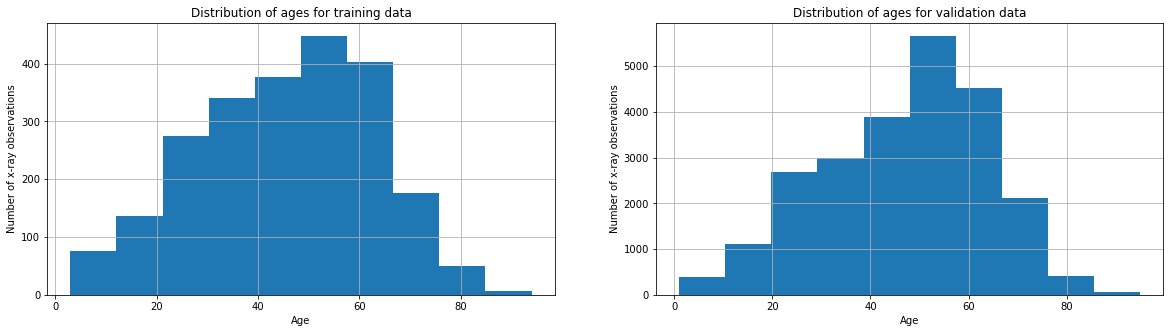

In [10]:
# Compare age distributions of training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Patient Age'].hist(ax=axes[0],figsize=(20,5))
valid_df['Patient Age'].hist(ax=axes[1],figsize=(20,5))
axes[0].set_title('Distribution of ages for training data')
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Distribution of ages for validation data')
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

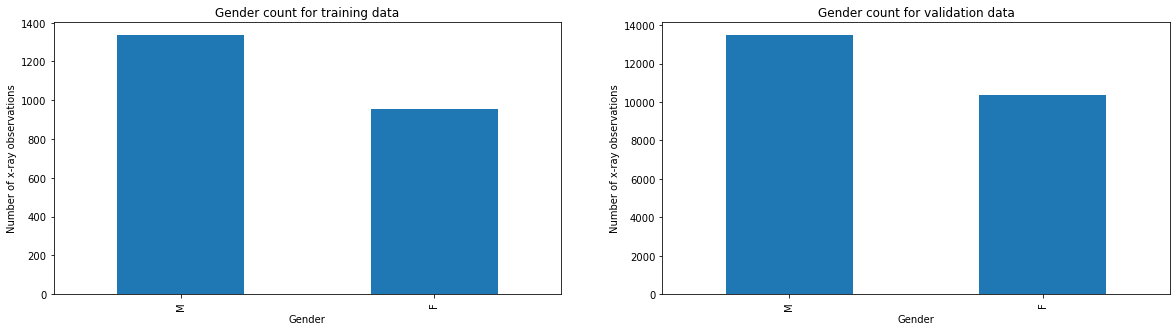

In [11]:
# Compare gender between training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Patient Gender'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['Patient Gender'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('Gender count for training data')
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Gender count for validation data')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

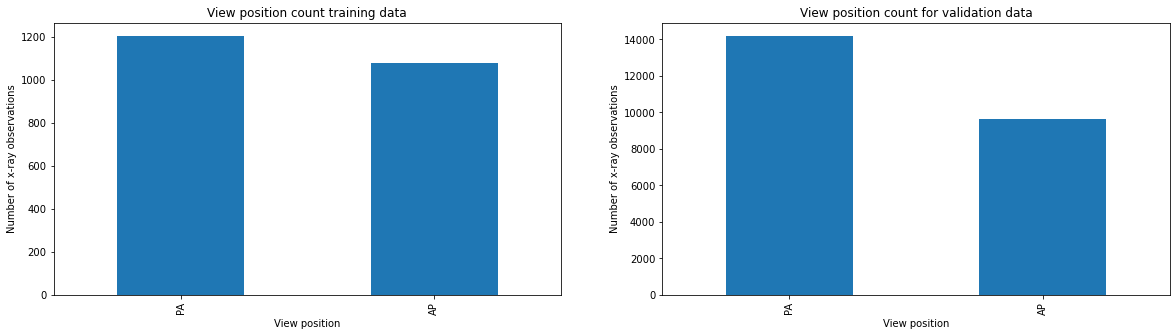

In [12]:
# Compare view position training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['View Position'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['View Position'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('View position count training data')
axes[0].set_xlabel("View position")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('View position count for validation data')
axes[1].set_xlabel("View position")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

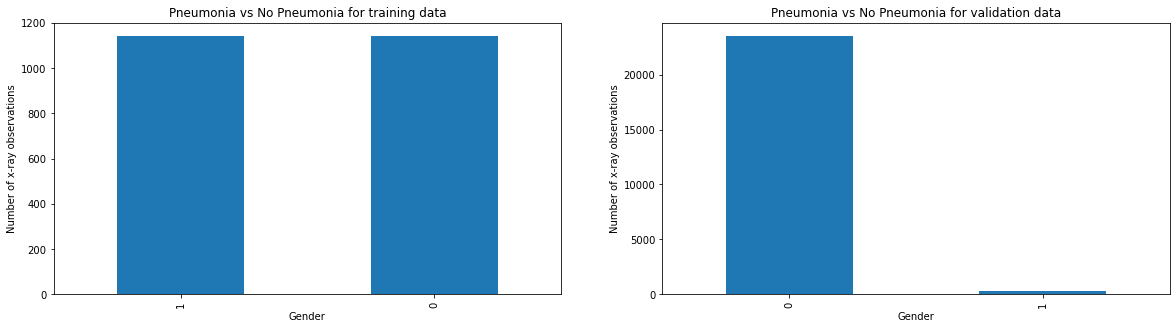

In [13]:
# Compare Pneumonia vs No Pneumonia cases between training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Pneumonia'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['Pneumonia'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('Pneumonia vs No Pneumonia for training data')
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Pneumonia vs No Pneumonia for validation data')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of x-ray observations")

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
# Define image size
IMG_SIZE = (224, 224)

In [15]:
def my_image_augmentation(train=True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size =IMG_SIZE , 
                                          batch_size = 16 
                                          )



    return train_gen


def make_val_gen(df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    idg = my_image_augmentation(train=False)

    val_gen = idg.flow_from_dataframe(dataframe=df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size =IMG_SIZE , 
                                          batch_size = 2000
                                          )


    return val_gen

In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(valid_df)
valX, valY = val_gen.next()

Found 2288 validated image filenames belonging to 2 classes.
Found 23833 validated image filenames belonging to 2 classes.


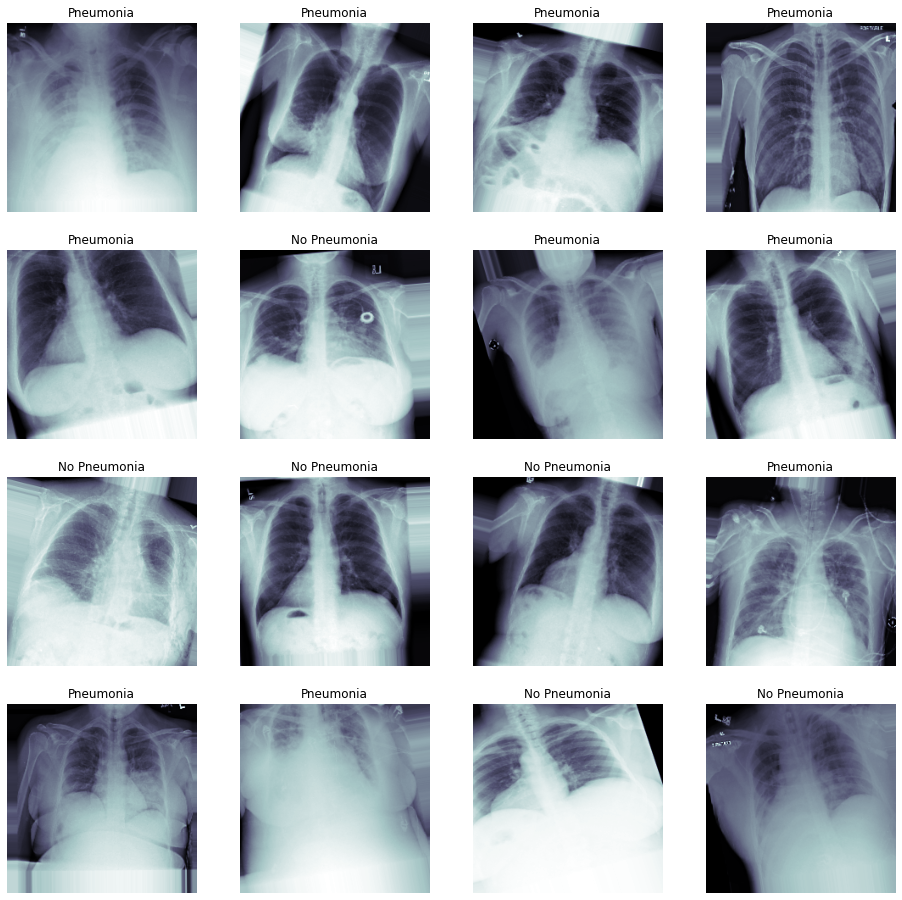

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    #for layer in vgg_model.layers[0:17]:
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    vgg_model.summary()
    return vgg_model


In [19]:
vgg_model = load_pretrained_model()


553467904/553467096 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [20]:

    vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    model = Sequential()
    model.add(load_pretrained_model())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer = Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
  
    return model
my_model = build_my_model()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=10)

callbacks_list = [checkpoint, early]
print(weight_path)


xray_class_my_model.best.hdf5


### Start training! 

In [23]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 15, 
                           callbacks = callbacks_list)

Epoch 1/15
143/143 [==============================] - 89s 622ms/step - loss: 0.8321 - binary_accuracy: 0.5175 - val_loss: 0.8236 - val_binary_accuracy: 0.0130

Epoch 00001: val_loss improved from inf to 0.82362, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
143/143 [==============================] - 79s 555ms/step - loss: 0.7243 - binary_accuracy: 0.5280 - val_loss: 0.8494 - val_binary_accuracy: 0.0190

Epoch 00002: val_loss did not improve from 0.82362
Epoch 3/15
143/143 [==============================] - 80s 557ms/step - loss: 0.7015 - binary_accuracy: 0.5223 - val_loss: 0.6839 - val_binary_accuracy: 0.5925

Epoch 00003: val_loss improved from 0.82362 to 0.68386, saving model to xray_class_my_model.best.hdf5
Epoch 4/15
143/143 [==============================] - 79s 553ms/step - loss: 0.6931 - binary_accuracy: 0.5315 - val_loss: 0.6117 - val_binary_accuracy: 0.7140

Epoch 00004: val_loss improved from 0.68386 to 0.61170, saving model to xray_class_my_model.best.hdf5
Epoch 5

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

2000/2000 [==============================] - 26s 13ms/step


#### Distribution of predictions for our validation data.

(array([  7.,  10.,   8.,  24.,  41.,  57.,  95.,  84., 135., 157., 123.,
        136., 153., 133., 108., 102., 103., 105., 108., 110.,  88.,  60.,
         36.,  14.,   3.]),
 array([0.08371896, 0.1086665 , 0.13361403, 0.15856157, 0.18350911,
        0.20845665, 0.23340419, 0.25835174, 0.28329927, 0.3082468 ,
        0.33319435, 0.35814187, 0.38308942, 0.40803695, 0.4329845 ,
        0.45793203, 0.48287958, 0.5078271 , 0.5327746 , 0.5577222 ,
        0.58266973, 0.60761726, 0.6325648 , 0.65751237, 0.6824599 ,
        0.7074074 ], dtype=float32),
 <a list of 25 Patch objects>)

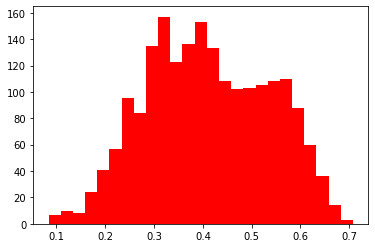

In [25]:
## plot figures
plt.hist(pred_Y, bins=25, color='red')

The distribution looks normal or Gaussian distribution

### History

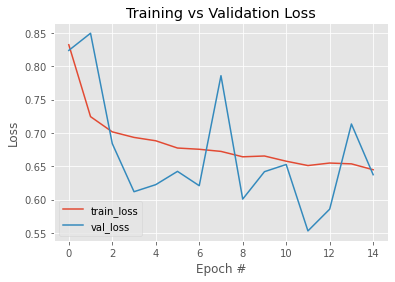

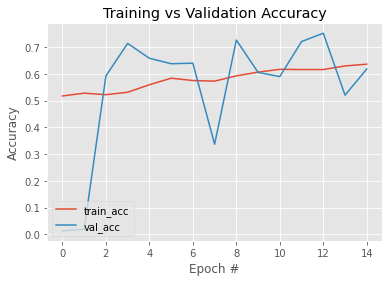

In [26]:
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    return
plot_history(history)

The training looks like unstable even using 15 epochs from the pre-training which was 10 epochs no big changes

In [27]:
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve,f1_score, confusion_matrix


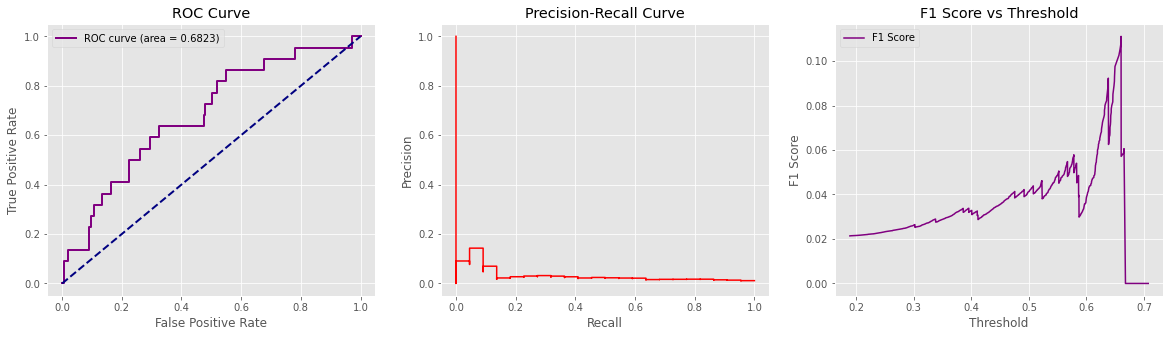

In [28]:
def plot_auc(valY, pred_Y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

    # Todo
    fpr, tpr, _ = roc_curve(valY, pred_Y)
    roc_auc = auc(fpr, tpr)
    
    # Calculate f1 vs threshold scores
    f1_scores = []
    for i in thresholds:
        f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
        f1_scores.append(f1)
        
    
    
    # Plot charts
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

    lw = 2
    ax1.plot(fpr, tpr, color='purple', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.title.set_text('ROC Curve')
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2.step(recall, precision, color='red', where='post')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.title.set_text('Precision-Recall Curve')
    ax2.grid(True)

    ax3.plot(thresholds, f1_scores, label = 'F1 Score', color='purple')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('F1 Score')
    ax3.title.set_text('F1 Score vs Threshold')
    ax3.legend(loc="upper left")
    ax3.grid(True)

    plt.show()
    return
    
plot_auc(valY, pred_Y)


The AUC suggests an 79% chance that the radiologist reading the image will correctly distinguish a normal from pneumonia to non pneumoninia patient based on the ordering of the image ratings

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

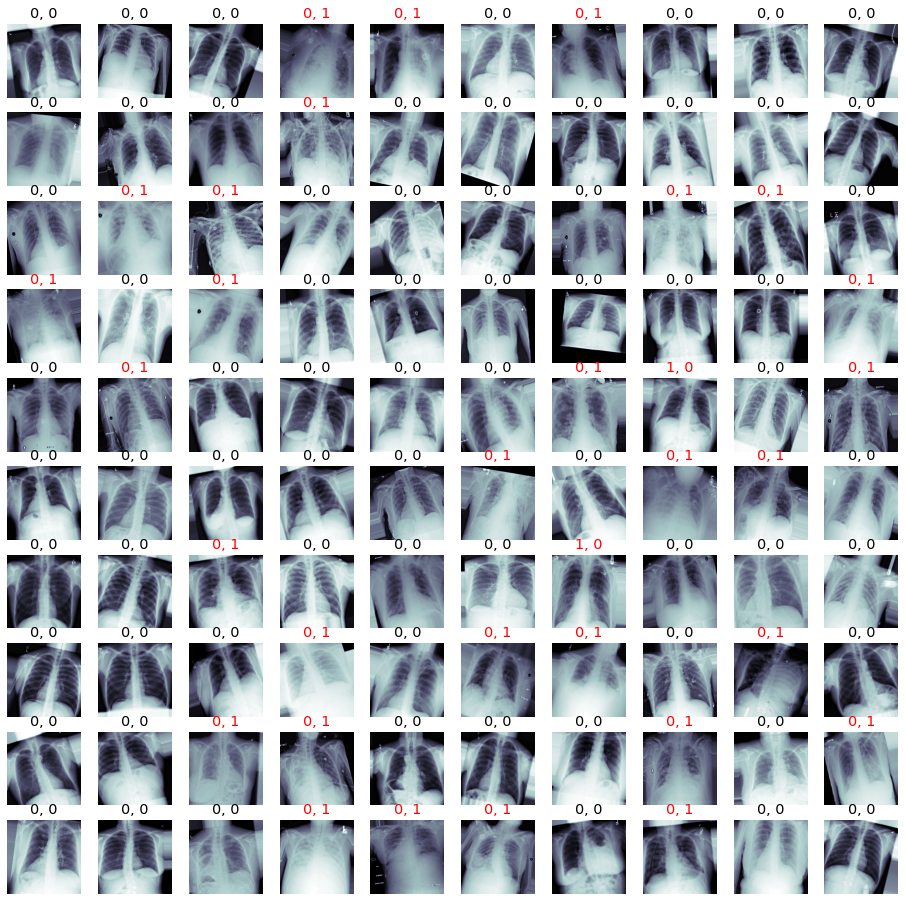

In [29]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.05:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0', color='red')
    else:
        if pred_Y[i] > 0.05: 
            c_ax.set_title('0, 1', color='red')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1


## Explain

In [30]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [40]:
from sklearn.metrics import classification_report

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

fpr, tpr, _ = roc_curve(valY, pred_Y)
roc_auc = auc(fpr, tpr)
    
    # Calculate f1 vs threshold scores
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)
        

for threshold in [0.05, 0.015, 0.4, 0.6, 0.8]:
    print("threshold:", threshold)
    print("----------")
    y_pred = [0 if y < threshold else 1 for y in pred_Y]

  # from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valY, y_pred)

  # Pandas 'crosstab' displays a better formated confusion matrix than the one in sklearn
cm = pd.crosstab(pd.Series(valY),
                 pd.Series(y_pred),
                 rownames=['Reality'],
                 colnames=['Predicted'],
                 margins=True)
print(cm)



print("Classification report:")
print(classification_report(valY, y_pred))

    

threshold: 0.05
----------
threshold: 0.015
----------
threshold: 0.4
----------
threshold: 0.6
----------
threshold: 0.8
----------
Predicted     0   All
Reality              
0.0        1978  1978
1.0          22    22
All        2000  2000
Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1978
         1.0       0.00      0.00      0.00        22

    accuracy                           0.99      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.98      0.99      0.98      2000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Threshold value, the model does not clearly classifying positive Pneumonia cases 

In [32]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)